In [11]:
#Checking functions

def XD_fitting_X( X = None, Xcov=None, 
        pickleFileName = 'pickle/XD_fitting_test.pkl', 
        init_params = None, 
        suffix='', 
        mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, verbose=False ):

    from astroML.decorators import pickle_results
    @pickle_results(pickleFileName, verbose = True)
    def compute_XD(X, Xcov, init_params = None, n_iter=500, 
    verbose=False, n_cl = None, tol=1E-5):
        if init_params != None : 
            n_cl = 10

        if n_cl is None : 
            n_cl,_,_= _FindOptimalN( np.arange(2, 50, 2), X, 
            pickleFileName = pickleFileName+'.n_cluster' , suffix = '')

        clf= XDGMM(n_cl, n_iter=n_iter, tol=tol, verbose=verbose)
        clf.fit(X, Xcov, init_params = init_params)
        return clf

    if X is None: 
        import pickle 
        f = open(pickleFileName, 'rb')
        pickle = pickle.load(f, encoding="bytes")
        clf = pickle['retval']
    else:
        #X, Xcov = mixing_color(data, mag=mag, err=err, filter=filter, 
        #suffix = suffix, no_zband=False)
        clf = compute_XD(X, Xcov, init_params=init_params, n_cl = n_cl, 
        n_iter = n_iter, tol=tol, verbose=verbose)
    return clf

In [1]:
#Y1 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS import priorCut_test

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, u

In [3]:
#Running Su pickle

import pickle

# Su's pickle file: changing from 'b'
outdir = '../code/output/n2/'
cmass_su_pickle = outdir+'gold_st82_XD_cmass_full_tol1e5.pkl'  # cmass Su
cmass_su_no_pickle = outdir+'gold_st82_XD_no_full_tol1e5.pkl' # noncmass Su
#clf_cmass_su = XD_fitting_X( None, None, pickleFileName = cmass_su_pickle)

f = open(cmass_su_pickle, 'rb')
g = open(cmass_su_no_pickle, 'rb')

clf_cmass_su = pickle.load(f, encoding="latin1")
clf_cmass_su = clf_cmass_su['retval']
clf_nocmass_su = pickle.load(g, encoding="latin1")
clf_nocmass_su = clf_nocmass_su['retval']
X_sample_cmass_su = clf_cmass_su.sample(200000)        # non-cmass model
X_sample_nocmass_su = clf_nocmass_su.sample(200000)
print(clf_cmass_su)
print(clf_nocmass_su)

In [8]:
#compare pickle files -- Su versus Beverly

#Probability function comparision (my full run versus Su's run):
#(two random samples from the probability functions: pickle file)

# my pickle file
outdir = '../output/test/fitting/'
cmass_pickle = outdir+'gauss_cmass_v4.pkl'
no_pickle = outdir+'gauss_no_v4.pkl'
clf_cmass = XD_fitting_X( None, None, pickleFileName = cmass_pickle) 
clf_nocmass = XD_fitting_X( None, None, pickleFileName = no_pickle) 
X_sample_nocmass_warner = clf_nocmass.sample(200000) 
X_sample_cmass_warner = clf_cmass.sample(200000) # -- makes random sample from trained pickle file
#output of XD Con.

In [9]:
# Comparison. beverly vs su sample from the fitted gaussian mixture model (visual)
#comparison of fitted function: trained versus fitted
doVisualization_1d( data=[X_sample_nocmass_su, X_sample_nocmass_warner], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['X_sample_nocmass_su', 'X_sample_nocmass_warner'], 
                   weight = [None,None], 
                   nbins=100, filename = 'test.png')

Using central 100% to set range.


In [19]:
help(doVisualization_1d)

Help on function doVisualization_1d in module xd:

doVisualization_1d(data=None, labels=None, ranges=None, name=None, weight=[None, None], color=['grey', 'tab:blue', 'tab:orange', 'tab:green'], nbins=100, filename=None)



In [10]:
#read in gold catalogs here:
##ST82 REGION catalog:

train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
    
def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [4]:
##SPT REGION catalog:

# Calling Y1 GOLD in a small square area 
input_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/'
input_keyword = 'Y1A1_GOLD_slr_ebv_'
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G','SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z','EBV']
gold_spt = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)
gold_spt = gold_spt[(gold_spt['MODEST_CLASS'] == 1)&(gold_spt['FLAGS_GOLD'] == 0 )]

#correct for SFD98:
params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_spt = RemovingSLRReddening(gold_spt)
        gold_spt = AddingSFD98Reddening(gold_spt, kind='SPT')
        
# Apply the same color/mag cuts to exclude extreme color/mag sources //
mask_magcut = priorCut_test(gold_spt)
gold_spt = gold_spt[mask_magcut]
        
print(gold_spt.size)


Calling catalogs >>>
Y1A1_GOLD_slr_ebv_000007.fits
Y1A1_GOLD_slr_ebv_000015.fits
Y1A1_GOLD_slr_ebv_000008.fits
Y1A1_GOLD_slr_ebv_000010.fits
Y1A1_GOLD_slr_ebv_000009.fits
Y1A1_GOLD_slr_ebv_000014.fits
Y1A1_GOLD_slr_ebv_000003.fits
Y1A1_GOLD_slr_ebv_000011.fits
Y1A1_GOLD_slr_ebv_000004.fits
Y1A1_GOLD_slr_ebv_000012.fits
Y1A1_GOLD_slr_ebv_000005.fits
Y1A1_GOLD_slr_ebv_000013.fits
Y1A1_GOLD_slr_ebv_000001.fits
Y1A1_GOLD_slr_ebv_000006.fits
Y1A1_GOLD_slr_ebv_000002.fits
reading 1/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000007.fits
reading 2/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000015.fits
reading 3/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000008.fits
reading 4/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000010.fits
reading 5/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_slr_ebv_000009.fits
reading 6/15 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/Y1A1_GOLD_sl

In [5]:
#takes 1 percent of spt sample:
print(gold_spt.size)
gold_spt_random_ind = np.random.choice(np.arange(gold_spt.size), size = int(gold_spt.size/100))
gold_spt_random = gold_spt[gold_spt_random_ind]
print(gold_spt_random.size)

7015838
70158


In [11]:
#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)
gold_spt = keepGoodRegion(gold_spt)
print(gold_spt.size)

694475
7015838


In [18]:
###FIGURE 4

#cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
cmass_fraction = 0.01819935922819396
#call in catalogs
# Assigning CMASS probabilities to Gold Y1 in Stripe 82.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] #1)magnitude cut, 2)making colors
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
clean_dmass_prob = assignCMASSProb(clean_cmass_data_des, clf_cmass_su, clf_nocmass_su, 
                     cmass_fraction =cmass_fraction
, 
                     mag=mag, err=err, filter=filter )
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82 = clean_dmass_prob  # -- this is being plotted as blue distr.
'''
# Assigning CMASS probabilities to Gold Y1 in SPT.
mag = ['MAG_MODEL', 'MAG_DETMODEL'] 
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] 
filter = ['G', 'R', 'I']
gold_spt_test = assignCMASSProb(gold_spt_random, clf_cmass_su, clf_nocmass_su, 
                     cmass_fraction = cmass_fraction
, 
                     mag=mag, err=err, filter=filter)
#dmass_spt = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
#gold_spt data
#XD of y1 gold des in spt -- with membership probability
dmass_spt = gold_spt_test'''

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


"\n# Assigning CMASS probabilities to Gold Y1 in SPT.\nmag = ['MAG_MODEL', 'MAG_DETMODEL'] \nerr = ['MAGERR_MODEL', 'MAGERR_DETMODEL'] \nfilter = ['G', 'R', 'I']\ngold_spt_test = assignCMASSProb(gold_spt_random, clf_cmass_su, clf_nocmass_su, \n                     cmass_fraction = cmass_fraction\n, \n                     mag=mag, err=err, filter=filter)\n#dmass_spt = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')\n#gold_spt data\n#XD of y1 gold des in spt -- with membership probability\ndmass_spt = gold_spt_test"

In [19]:
#cmass catalog

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

#matching:
# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]

print(nocmass.size)

print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 13046
681836
('num of cmass in des side', 12639, '(5%)')


0 14.850858453991615
1 9.344093678297334
2 7.904106337526703
3 7.61927367671493
4 7.120816520294328
5 7.025872300023736
6 7.896194319170821
7 9.05926101748556
8 11.345834322335628
9 17.83368937415935


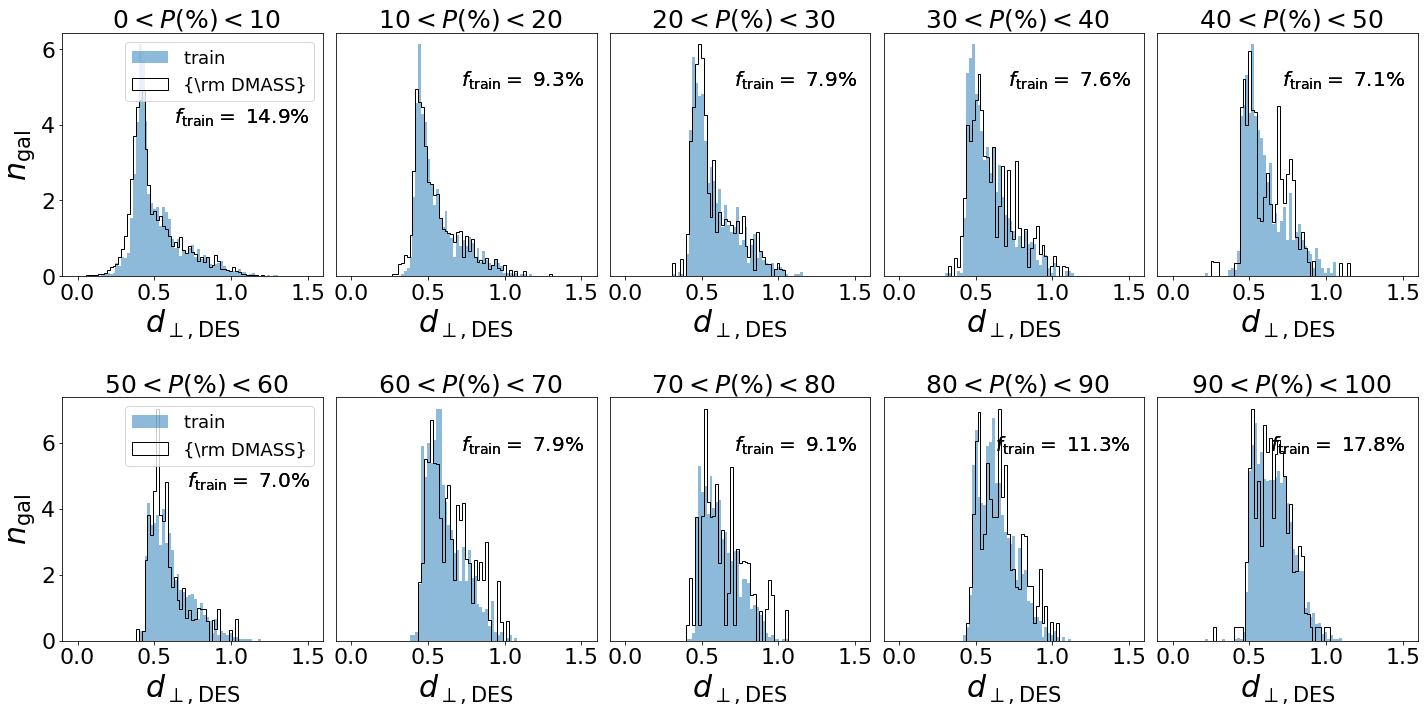

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

probcut = 0.0
np.linspace(0.0, 1.5, 6)

labels = [r'${\rm train}$', r'{\rm DMASS}']
catlist = [dmass_st82, dmass_spt[dmass_spt['CMASS_PROB']>0.00]]
cbin = np.linspace(0.,1.5, 80)
probcut = 0
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.ravel()

for i in range(10):     
    for la, cat in zip(labels, catlist) :     
        mask = (cat['CMASS_PROB'] > probcut) & (cat['CMASS_PROB'] < probcut + 0.1) \
        & (cat['CMASS_PROB'] > 0.00) # & ( (cat['MAG_MODEL_G']- cat['MAG_MODEL_R']) < 1.6) #galaxies in different prob bins
        
        histtype = 'stepfilled'
        alpha = 0.5
        if la == r'{\rm DMASS}' : # plotting transparent distribution: spt region
            Nhist, _,_ = ax[i].hist( (cat['MAG_DETMODEL_R']-cat['MAG_DETMODEL_I']- (cat['MAG_DETMODEL_G']-cat['MAG_DETMODEL_R'])/8.)[mask], \
                    bins = cbin, density= True, alpha = 1.0, label = la + ''.format(np.sum(mask)*1./mask.size*100), \
                       histtype='step', color = 'black', weights = cat[mask]['CMASS_PROB']);  
        
        else : #plotting training data: blue distribution: st82 region-- weights needed to be applied with dmass
            Nhist2, _, _=ax[i].hist( (cat['MAG_DETMODEL_R']-cat['MAG_DETMODEL_I']- (cat['MAG_DETMODEL_G']-cat['MAG_DETMODEL_R'])/8.)[mask], \
                    bins = cbin, density = True, alpha = alpha, label = la + ''.format(np.sum(mask)*1./mask.size*100), \
                     histtype=histtype); 
            fraction_train = np.sum(mask)*1./mask.size*100 #total cmass galaxies in des catalog/ total galaxies in des cat.
            print(i, fraction_train)
 #does not have weights           
        #print probcut, probcut+0.1, np.sum(mask), la
        #print i,
        tag = r' ${:0.0f} < P(\%) < {:0.0f}$'.format(probcut*100, probcut*100+10)
        
        #ax[i].set_xlim(0, 1.0)
        if i in [0, 5]: 
            ax[i].legend(loc=1, fontsize = 18)
            ax[i].set_ylabel(r'$n_{\rm gal}$', fontsize = 30)
            
#            ax[i].set_yticks([0, max(Nhist.max(), Nhist2.max())])
#            ax[i].set_yticklabels(['$0$', '$1$'])
            ax[i].text(0.95, 0.7, r'$f_{\rm train}=$'+'$~{:0.1f}\%$'.format(fraction_train), 
                   fontsize = 20, ha='right', va='top', transform=ax[i].transAxes)
        else : 
            #pass
            ax[i].get_yaxis().set_visible(False)
            ax[i].text(0.95, 0.85, r'$f_{\rm train}=$'+'$~{:0.1f}\%$'.format(fraction_train), 
                   fontsize = 20, ha='right', va='top', transform=ax[i].transAxes)
        ax[i].set_title(tag, fontsize=25)
        ax[i].set_xlabel(r'$d_{\perp, {\rm DES}}$', fontsize = 30)
        ax[i].set_xlim(-0.1, 1.6)
        ax[i].set_xticks(np.linspace(0.0, 1.5, 4))
        #ax[i].set_xticklabels(np.linspace(0.0, 1.5, 6))
        #ax[i].set_ylabel(r'$n(z)$')
        #ax[i].get_yaxis().set_visible(False)
        ax[i].tick_params(labelsize = 22)
        #ax[i].set_ylim(0,7)
        
        #ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        #elif i != 2 : ax[i].get_yaxis().set_visible(False)
        
    probcut += 0.1
    
#ax[0].get_yaxis().set_visible(True)
#ax[5].get_yaxis().set_visible(True)


fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.5);

#algorithm slightly different? Distributions do not match
#python differences?

#training data = blue distribution

#fraction is: ratio of cmass galaxies/total gold des galaxies
#des versus cmass data, change to reflect dmass